In [1]:
DATASET_PATH = './images'
MODEL_PATH = './resnet18_letters.pth'

Вам предстоит создать алгоритм по деформации (выравниваню) автомобильных номеров и поместить его в функцию img_deformation.


! Вы не можете менять заданную OCR модель (дообучать тоже нельзя) и заданные шаблоны по разбиению изображения.

! Допустимы небольшие измениния трех основных .py файлов, если в этом есть необходимость для встраивания в ваши решения. Но их функционал должен быть сохранен.

# Файлы для работы с шаблонами

В разделе "Алогритм" показано что для чего нужно, так что имеет смысл сначала посетить его

## model.py

In [10]:
pip install torch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
pip install torchvision

  Using cached torchvision-0.18.1-cp311-cp311-win_amd64.whl (1.2 MB)
  Using cached pillow-10.4.0-cp311-cp311-win_amd64.whl (2.6 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18

label2letter = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9",
    10: "A", 11: "B", 12: "C", 13: "E", 14: "H", 15: "K", 16: "M", 17: "O", 18: "P", 19: "T", 20: "X", 21: "Y"
}

class LettersPrediction(object):
    def __init__(self):
        self.model = resnet18()
        self.model.fc = nn.Linear(self.model.fc.in_features, out_features=22)
        self.model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))
        self.model.eval()

        self.imgsz = 64

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((self.imgsz, self.imgsz)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def predict(self, img):
        input_tensor = self.transform(img)
        output_tensor = self.model(input_tensor.unsqueeze(0))
        predicted = torch.argmax(output_tensor)
        return label2letter[predicted.item()]

    def predict_series(self, imgs):
        s = ""
        for img in imgs:
            s += self.predict(img)
        return s

## template.py

Разбивает изображение на части по шаблонам

In [3]:
from pathlib import Path
import numpy as np

two_digit_region_template = [
    {'pos': 1, 'p1': (0.067, 0.250), 'p2': (0.177, 0.92)},
    {'pos': 2, 'p1': (0.19, 0.100), 'p2': (0.3, 0.92)},
    {'pos': 3, 'p1': (0.3, 0.100), 'p2': (0.41, 0.92)},
    {'pos': 4, 'p1': (0.41, 0.100), 'p2': (0.52, 0.92)},
    {'pos': 5, 'p1': (0.53, 0.250), 'p2': (0.64, 0.92)},
    {'pos': 6, 'p1': (0.64, 0.250), 'p2': (0.75, 0.92)},
    {'pos': 7, 'p1': (0.77, 0.05), 'p2': (0.86, 0.7)},
    {'pos': 8, 'p1': (0.86, 0.05), 'p2': (0.95, 0.7)}
]

three_digit_region_template = [
    {'pos': 1, 'p1': (0.05, 0.250), 'p2': (0.16, 0.92)},
    {'pos': 2, 'p1': (0.16, 0.100), 'p2': (0.27, 0.92)},
    {'pos': 3, 'p1': (0.265, 0.100), 'p2': (0.375, 0.92)},
    {'pos': 4, 'p1': (0.37, 0.100), 'p2': (0.48, 0.92)},
    {'pos': 5, 'p1': (0.475, 0.250), 'p2': (0.585, 0.92)},
    {'pos': 6, 'p1': (0.58, 0.250), 'p2': (0.69, 0.92)},
    {'pos': 7, 'p1': (0.71, 0.05), 'p2': (0.795, 0.7)},
    {'pos': 8, 'p1': (0.79, 0.05), 'p2': (0.875, 0.7)},
    {'pos': 9, 'p1': (0.87, 0.05), 'p2': (0.96, 0.7)}
]

def apply_template(img, region_length):
    if region_length == 2:
        pattern = two_digit_region_template
    elif region_length == 3:
        pattern = three_digit_region_template
    else:
       raise ValueError("Неподдерживаемое разбиение на регионы. Поддерживаются только 2 и 3.")

    H, W, _ = img.shape

    if H != 112 or W != 512:
        raise ValueError("Форма изображения должна быть 512x112")

    crops = []
    for pos in pattern:
        sx, sy, ex, ey = *pos["p1"], *pos["p2"]
        sx, sy, ex, ey = sx * W, sy * H, ex * W, ey * H
        sx, sy, ex, ey = map(int, [sx, sy, ex, ey])
        crops.append(img[sy : ey, sx : ex])

    return crops


## Функция для деформации

Пропишите логику алгоритма по деформации внутри фунции img_deformation

In [4]:
def img_deformation(img):
    # return img
    def order_points(pts):
        # Нахождение центра объекта
        center = np.mean(pts)

        # Перемещение систем координат в центр объекта
        shifted = pts - center

        # Нахождение углов, стянутых из центра в каждую угловую точку.
        theta = np.arctan2(shifted[:, 0], shifted[:, 1])

        # Возвращение вершин упорядоченных по Тете
        ind = np.argsort(theta)
        return pts[ind]
    
    def getContours(img, orig):
        # Получение размеров изображения
        height, width = img.shape[:2] 
        biggest = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.int32)  # Массив с размерами изображения
        maxArea = 500

        # Создание копии исходного изображения чтобы потом вернуть его
        imgContour = orig.copy() 
        contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)

        # Также указавыем индекс
        index = -1
        for i, cnt in enumerate(contours):
            area = cv2.contourArea(cnt)
            if area > 500:
                peri = cv2.arcLength(cnt, True)
                approx = cv2.approxPolyDP(cnt, 0.02*peri, True)
                # print(approx)
                if area > maxArea and len(approx) == 4:
                    biggest = approx
                    maxArea = area
                    index = i  # Сохраняем индекс контура

        if maxArea == 0:
            maxArea = (width-1) * (height-1)

        warped = None  
        if index != None:
            cv2.drawContours(imgContour, contours, index, (255, 0, 0), 3)

            src = np.squeeze(biggest).astype(np.float32) # Source points

            # Получаем корректный порядок точек
            src = order_points(src)

            # Вычисляем ширины и высоты нового изображения
            widthA = np.linalg.norm(src[0] - src[1])
            widthB = np.linalg.norm(src[2] - src[3])
            maxWidth = max(int(widthA), int(widthB))

            heightA = np.linalg.norm(src[0] - src[3])
            heightB = np.linalg.norm(src[1] - src[2])
            maxHeight = max(int(heightA), int(heightB))

            # Определяем концевые точки
            dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype="float32")

            # Делаем преобразование перспективы
            M = cv2.getPerspectiveTransform(src, dst)

            # Деформирруем изображение
            warped = cv2.warpPerspective(orig, M, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)

            # Optionally resize the warped image to a fixed size if needed
            warped = cv2.resize(warped, (maxWidth, maxHeight))
            warped = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)
            warped = cv2.flip(warped, 1)


        return biggest, imgContour, warped  # Change - also return drawn image

    kernel = np.ones((3,3))
    image = img

    imgGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    imgBlur = cv2.GaussianBlur(imgGray,(5,5),1)
    imgCanny = cv2.Canny(imgBlur,150,200)        
    imgDial = cv2.dilate(imgCanny,kernel,iterations=2)
    imgThres = cv2.erode(imgDial,kernel,iterations=2)
    biggest, imgContour, warped = getContours(imgThres, image)  # Change

    titles = ['Original', 'Blur', 'Canny', 'Dilate', 'Threshold', 'Contours', 'Warped'] 
    images = [image[...,::-1],  imgBlur, imgCanny, imgDial, imgThres, imgContour, warped]
    return warped

## predict.py

Выполняет предсказание для изображений разбитых по 2 и 3 шаблону

In [15]:
pip install tqdm

     -------------------------------------- 78.3/78.3 kB 256.7 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
pip install pandas

     -------------------------------------- 11.6/11.6 MB 109.2 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
pip install numpy==1.24.1

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
pip install model

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement model (from versions: none)
ERROR: No matching distribution found for model

[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import argparse
from pathlib import Path
from tqdm import tqdm

import cv2
import pandas as pd

# from template import apply_template
# from model import LettersPrediction

data_path = Path(DATASET_PATH)


regions_type = [2, 3]
model = LettersPrediction()


result = []
for p in tqdm(data_path.iterdir()):

    if not p.suffix in [".png", ".jpg", ".jpeg"]:
        continue
    result.append(
        {
            "image_name": p.stem,
            "prediction_region_length_2": "",
            "prediction_region_length_3": ""
        }
    )

    img = cv2.imread(str(p))

    #вызов фунции деформации
    img = img_deformation(img)
    ########################

    img = cv2.resize(img, (512,112))

    for region_type in regions_type:

        crops = apply_template(img, region_type)

        lp_number = model.predict_series(crops)
        result[-1][f"prediction_region_length_{region_type}"] = lp_number

pd.DataFrame(result).to_csv('modelPredict.csv', index=False)

1028it [03:37,  4.73it/s]


# Алгоритм

![](https://sun9-2.userapi.com/impg/SfgCnkIYJeC_4clAh69dvC6ZwmBT9dLmMkh25A/DvScgey4ZCg.jpg?size=1916x1079&quality=96&sign=2ef5e9fadc1d8635c4963fb99affd07d&type=album)

In [9]:
pip install matplotlib

  Using cached matplotlib-3.9.1-cp311-cp311-win_amd64.whl (8.0 MB)
  Using cached contourpy-1.2.1-cp311-cp311-win_amd64.whl (188 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached fonttools-4.53.1-cp311-cp311-win_amd64.whl (2.2 MB)
  Using cached kiwisolver-1.4.5-cp311-cp311-win_amd64.whl (56 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import matplotlib.pyplot as plt
import os

#Рисует на изображение template
def draw_regions(img, region_length):
    if region_length == 2:
        pattern = two_digit_region_template
    elif region_length == 3:
        pattern = three_digit_region_template
    else:
        raise ValueError("Неподдерживаемое разбиение на регионы. Поддерживаются только 2 и 3.")

    H, W, _ = img.shape

    if H != 112 or W != 512:
        raise ValueError("Форма изображения должна быть 512x112")

    for pos in pattern:
        sx, sy, ex, ey = *pos["p1"], *pos["p2"]
        sx, sy, ex, ey = int(sx * W), int(sy * H), int(ex * W), int(ey * H)
        cv2.rectangle(img, (sx, sy), (ex, ey), (0, 255, 0), 2)

    return img

#Визуализирует изображения из датасета
def draw(folder_path, show_template=False, template=2):

    file_list = os.listdir(folder_path)[:5] # Выбираем 5 изображений для визуализации
    image_files = [f for f in file_list if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Устанавливаем количество изображений на строку
    images_per_row = 5

    num_rows = len(image_files) // images_per_row + int(len(image_files) % images_per_row != 0)
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))

    for i in range(num_rows * images_per_row):
        if i < len(image_files):
            ax = axes.flat[i]
            img_path = os.path.join(folder_path, image_files[i])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if show_template:
              img = img_deformation(img)
              img = cv2.resize(img, (512,112))
              img_with_rectangles = draw_regions(img, template)

            ax.imshow(img)
            ax.axis('off')
            ax.set_title(os.path.basename(img_path))
        else:
            axes.flat[i].axis('off')

    plt.tight_layout()
    plt.show()


Визуализируем изображения из датасета

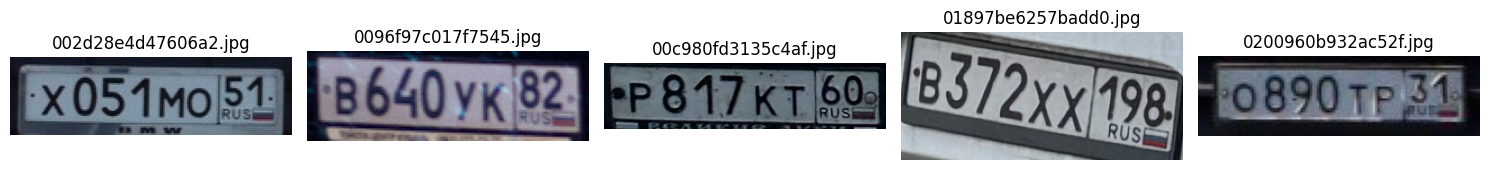

In [13]:
draw(DATASET_PATH, show_template=False)

Теперь визуализируем шаблон 2 для каждого изображения

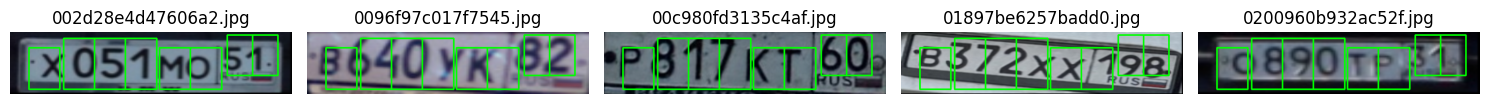

In [14]:
draw(DATASET_PATH, show_template=True)

Теперь визуализируем шаблон 3 для каждого изображения

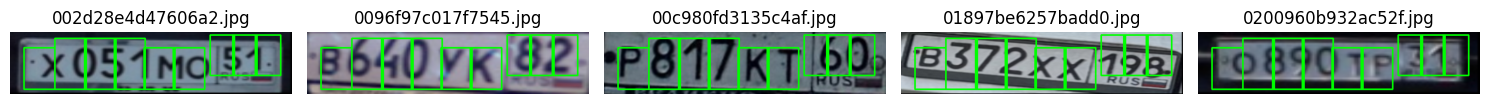

In [15]:
draw(DATASET_PATH, show_template=True, template = 3)

# Вывод модели

In [17]:
df = pd.read_csv('./modelPredict.csv')

Модель делает предсказание разбивая изображение и по шаблону 2 и по шаблону 3.

In [18]:
df

,image_name,prediction_region_length_2,prediction_region_length_3
0,002d28e4d47606a2,4OE1MO5E,2OE4HOE4H
1,0096f97c017f7545,E484A192,E642MC622
2,00c980fd3135c4af,48E1CH60,E817KTHYO
3,01897be6257badd0,44424266,5422CC446
4,0200960b932ac52f,589OT4E1,545OM2311
...,...,...,...
1023,fe8f3cff0cf76166,Y929EEB4,Y9254EH64
1024,fed01b5793ae24dc,M61444T3,M614HOT73
1025,ff670e356ab0fee5,C65OT15O,Y45OPPTYO
1026,ff84142ca87fed63,0P116497,0012HO777
